In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

In [4]:
current_datetime =  datetime.now()
current_date_str = str(current_datetime.date()).replace('-','_')
output_directory = '../data/processed/'
output_filename = current_date_str + '_clean_player_data.csv'
file_path = output_directory + output_filename

df = pd.read_csv(file_path)

duplicate_players = df[df.duplicated(subset=['Player'], keep=False)]

duplicate_players_same_team = duplicate_players[duplicate_players.duplicated(subset=['Player', 'Team'], keep=False)]

df = df.drop_duplicates(subset=['Player', 'Team'], keep='first')



forward_df = df[(df['Pos'] == 'LW') | (df['Pos'] == 'RW') 
                      | (df['Pos'] == 'C') | (df['Pos'] == 'F') | (df['Pos'] == 'W')]


Lets take a look at our features and drop columns that will be irrelevant to our model

In [5]:
print(forward_df.columns)

Index(['Unnamed: 0', 'Player', 'Age', 'Pos', 'GP', 'G', 'A', 'PTS', '+/-',
       'PIM', 'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S', 'S%', 'TOI',
       'ATOI', 'OPS', 'DPS', 'PS', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%', 'Ht',
       'Wt', 'S/C', 'Exp', 'Team', 'specific_pos', 'Cap%', 'Salary'],
      dtype='object')


In [6]:
def prep_atoi(atoi_string):
    list = atoi_string.split(':')
    minutes = int(list[0])
    seconds = int(list[1])

    return minutes + (seconds/60)

In [7]:
columns_to_drop = ['Unnamed: 0', 'Pos', 'EV.1', 'PP.1', 'SH.1', 'TOI',  'S/C','Team', 'specific_pos', 'Cap%', 'ATOI', 'Ht', 'Wt' ]

forward_df['clean_atoi'] = forward_df['ATOI'].apply(prep_atoi)

df = forward_df.drop(columns=columns_to_drop)
df = df.dropna()

/tmp/ipykernel_50834/3807726870.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forward_df['clean_atoi'] = forward_df['ATOI'].apply(prep_atoi)


Next I want to normalize some statistics to per game. 

In [8]:
df.columns

Index(['Player', 'Age', 'GP', 'G', 'A', 'PTS', '+/-', 'PIM', 'EV', 'PP', 'SH',
       'GW', 'S', 'S%', 'OPS', 'DPS', 'PS', 'BLK', 'HIT', 'FOW', 'FOL', 'FO%',
       'Exp', 'Salary', 'clean_atoi'],
      dtype='object')

In [9]:

df['points_per_game'] = (df['G'] + df['A']) / df['GP']
df['PIM_pergame'] = df['PIM'] / df['GP']
df['shots_per_game'] = df['S'] / df['GP']
df['shot%_per_game'] = df['S%'] / df['GP']
df['hits_per_game'] = df['HIT'] / df['GP']
df['blocks_per_game'] = df['BLK'] / df['GP']

 
df = df.drop(columns=['G', 'A', 'PIM', 'S', 'S%', 'HIT', 'BLK', 'GP', 'PTS'])

Feature Importance Ranking:
1. Feature 'clean_atoi': 0.4691952181456199
2. Feature 'points_per_game': 0.15727095289803064
3. Feature 'Exp': 0.07772401505507749
4. Feature 'shots_per_game': 0.06754184657277604
5. Feature 'Age': 0.03531037404654649
6. Feature 'FO%': 0.020540204691241213
7. Feature '+/-': 0.01868607030247661
8. Feature 'FOL': 0.01772572446411685
9. Feature 'blocks_per_game': 0.016565845332162387
10. Feature 'PIM_pergame': 0.014627384892715103
11. Feature 'OPS': 0.013789939537970945
12. Feature 'hits_per_game': 0.013526973254801799
13. Feature 'FOW': 0.013254306261693277
14. Feature 'shot%_per_game': 0.012552735104395606
15. Feature 'PS': 0.01244333858895406
16. Feature 'EV': 0.011952263517611677
17. Feature 'PP': 0.009356935715882229
18. Feature 'DPS': 0.009022226285011519
19. Feature 'GW': 0.006687907933230656
20. Feature 'SH': 0.0022257373996856077


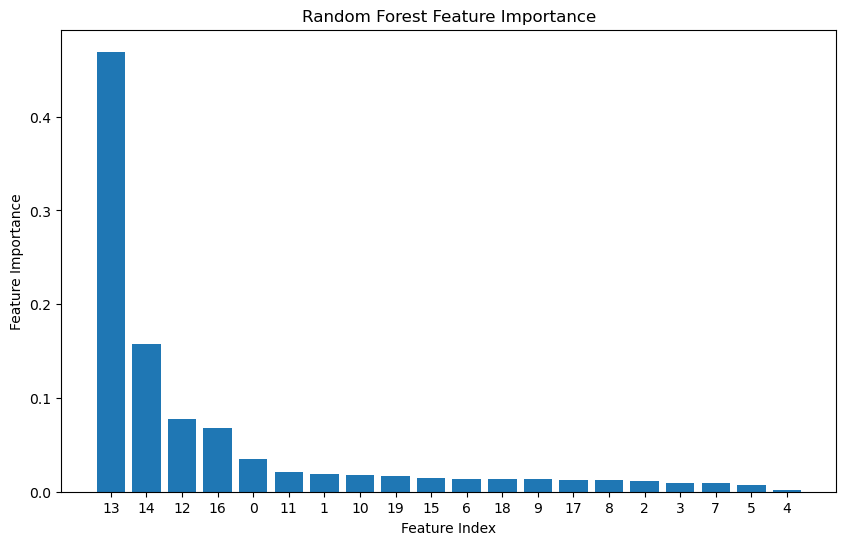

In [10]:
player_names = df['Player']


# Features (X) - Exclude the target column
X = df.drop(['Salary', 'Player'], axis=1)

# Target (y) - The column you want to predict
y = df['Salary']


X_encoded = pd.get_dummies(X)


# Split the data into training and testing sets
# Adjust the test_size parameter as needed
X_train, X_test, y_train, y_test, player_names_train, player_names_test = train_test_split(
    X_encoded, y, player_names, test_size=0.2, random_state=42
)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor()

# Fit the model to your training data
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get the indices of features sorted by importance
sorted_indices = np.argsort(feature_importances)[::-1]



# Print feature importance ranking with original column names
print("Feature Importance Ranking:")

ordered_feature_importance = []

for i, index in enumerate(sorted_indices):
    original_column_name = X_encoded.columns[index]
    ordered_feature_importance.append(original_column_name)
    print(f"{i + 1}. Feature '{original_column_name}': {feature_importances[index]}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), sorted_indices)
plt.xlabel("Feature Index")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


In [11]:
print(ordered_feature_importance[:7])

['clean_atoi', 'points_per_game', 'Exp', 'shots_per_game', 'Age', 'FO%', '+/-']


In [12]:
important_features = ['Player','Salary'] + ordered_feature_importance[:7] 


final_dataset = df[important_features]

Mean Squared Error: 2584269230921.441
R-squared: 0.6815873930795344


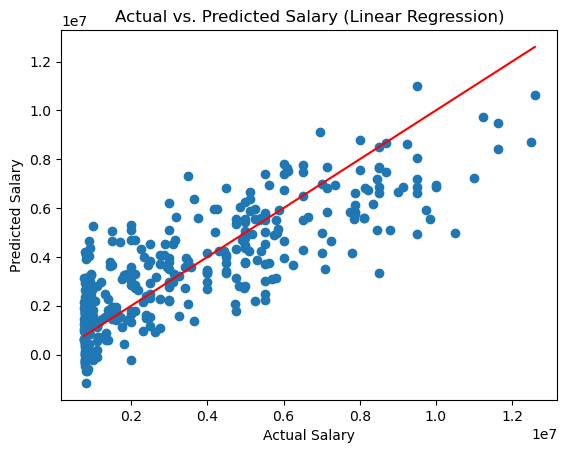

In [13]:
player_names = final_dataset['Player']

X = final_dataset.drop(['Salary', 'Player'], axis=1)

# Target (y) - The column you want to predict
y = final_dataset['Salary']

X_encoded = pd.get_dummies(X)


X_train, X_test, y_train, y_test, player_names_train, player_names_test = train_test_split(
    X_encoded, y, player_names, test_size=0.2, random_state=42
)


linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

predictions_linear = linear_model.predict(X)


results_df = pd.DataFrame({'Player': player_names, 'Actual_Salary': y, 'Predicted_Salary': predictions_linear})




# Evaluate the model
mse = mean_squared_error(y, predictions_linear)
r2 = r2_score(y, predictions_linear)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Plotting actual vs. predicted values
plt.scatter(y, predictions_linear)

plotting_values = np.linspace(np.min(y), np.max(y), 1000)
plt.plot(plotting_values, plotting_values, color='r')
plt.plot()
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salary (Linear Regression)")
plt.show()


Random Forest Model:
Mean Squared Error: 775769098758.0648
R-squared: 0.9044160499423581


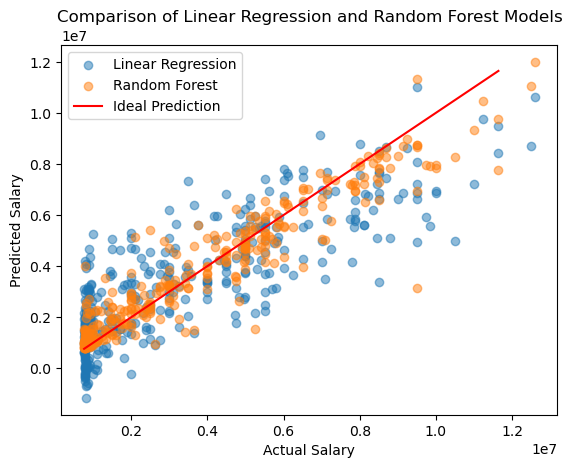

In [14]:
# Random Forest Model
random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)
predictions_rf = random_forest_model.predict(X_encoded)

# Evaluate Random Forest model
mse_rf = mean_squared_error(y, predictions_rf)
r2_rf = r2_score(y, predictions_rf)

print("\nRandom Forest Model:")
print("Mean Squared Error:", mse_rf)
print("R-squared:", r2_rf)

# Compare the models visually
plt.scatter(y, predictions_linear, label='Linear Regression', alpha=0.5)
plt.scatter(y, predictions_rf, label='Random Forest', alpha=0.5)

plt.plot(np.linspace(np.min(y_test), np.max(y_test), 100), np.linspace(np.min(y_test), np.max(y_test), 100), color='r', label='Ideal Prediction')

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Comparison of Linear Regression and Random Forest Models")
plt.legend()
plt.show()

In [15]:
results_df = pd.DataFrame({'Player': player_names, 'Actual_Salary': y, 'Predicted_Salary': predictions_rf})
results_df['difference'] = results_df['Actual_Salary'] - results_df['Predicted_Salary']
results_df['Actual_Salary'] = results_df['Actual_Salary'].apply(lambda x: "{:e}".format(x))
results_df['Predicted_Salary'] = results_df['Predicted_Salary'].apply(lambda x: "{:e}".format(x))



overpaid_df = results_df[results_df['difference'] > 0]
underpaid_df = results_df[results_df['difference'] < 0]


In [16]:
print(f'There are {results_df.shape[0]} forwards in the dataset and {overpaid_df.shape[0]} are overpaid, and {underpaid_df.shape[0]} are underpaid')

There are 378 forwards in the dataset and 147 are overpaid, and 231 are underpaid


In [17]:
overpaid_df.sort_values(by='difference', ascending=False).head(20)

,Player,Actual_Salary,Predicted_Salary,difference
400,Jamie Benn,9.500000e+06,3.127143e+06,6372857.10
0,Artemi Panarin,1.164286e+07,7.751606e+06,3891250.53
668,Jakob Silfverberg,5.250000e+06,1.546458e+06,3703541.67
200,Matthew Tkachuk,9.500000e+06,6.927225e+06,2572774.85
286,Brendan Gallagher,6.500000e+06,3.980750e+06,2519250.00
622,Jonathan Huberdeau,1.050000e+07,8.274183e+06,2225816.66
55,Jesperi Kotkaniemi,4.820000e+06,2.619467e+06,2200533.34
198,Aleksander Barkov,1.000000e+07,7.860351e+06,2139648.69
15,Barclay Goodrow,3.641667e+06,1.502875e+06,2138792.00
308,Dylan Cozens,7.100000e+06,5.010867e+06,2089133.31


In [18]:
underpaid_df.sort_values(by='difference', ascending=True).head(20)

,Player,Actual_Salary,Predicted_Salary,difference
184,Danton Heinen,7.750000e+05,3.993725e+06,-3218725.00
442,Nick Bjugstad,2.100000e+06,5.129464e+06,-3029464.29
304,Casey Mittelstadt,2.500000e+06,5.410911e+06,-2910910.71
95,Nic Dowd,1.300000e+06,3.534714e+06,-2234714.29
419,Colton Sissons,2.857143e+06,4.985914e+06,-2128771.29
159,Boone Jenner,3.750000e+06,5.618502e+06,-1868502.39
262,Nikita Kucherov,9.500000e+06,1.132554e+07,-1825540.26
45,Seth Jarvis,8.941670e+05,2.712373e+06,-1818205.62
376,Jonathan Drouin,8.250000e+05,2.574167e+06,-1749166.67
284,Sean Monahan,1.985000e+06,3.717250e+06,-1732250.00
